# Car Insurance Claims Fraud Detection using SMOTE
This project aims to enhance the accuracy of fraud detection in car insurance claims by addressing class imbalance through the application of Synthetic Minority Over-sampling Technique (SMOTE). Fraudulent claims are typically rare compared to legitimate ones, leading to imbalanced datasets that can negatively impact the performance of traditional machine learning models.

This project involves the development and evaluation of various classification models, such as Random Forest, Logistic Regression, Naïve Bayes, and kNN to detect fraudulent claims. By incorporating SMOTE, the project balances the dataset by synthetically generating new fraudulent claim instances, improving the models' ability to identify fraudulent activities without being biased toward the majority class. Performance metrics like precision, recall, F1-score, and AUC-ROC will be used to evaluate model effectiveness.

In [1]:
# Importing libaries
import numpy as np
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Importing pre-processing techniques
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Importing splitting techniques
from sklearn.model_selection import KFold

# Importing sampling techniques
from imblearn.over_sampling import SMOTE
from collections import Counter

# Importing ML libraries for classification
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, PrecisionRecallDisplay, auc


In [2]:
# Load card_transactions dataset
df = pd.read_csv('data/insurance_fraud.csv')

# View first 5 rows of dataset
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

# Data Cleaning

In [4]:
# Label encode and normalise dataset

categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64']).columns

# Label encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Normalise numerical columns
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,2,1.00,6,6,1,6,5,0.00,0,2,...,1,3,0,0,0,3,0,2,0.0,2
1,4,0.50,6,6,1,2,5,0.75,1,2,...,4,4,1,0,0,3,3,0,0.0,1
2,10,1.00,0,6,1,5,10,0.25,1,1,...,5,6,0,0,0,3,3,0,0.0,1
3,6,0.25,2,17,0,1,6,0.00,1,1,...,6,7,1,0,0,2,3,0,0.0,2
4,4,1.00,1,6,1,6,4,0.25,0,2,...,3,4,0,0,0,3,3,0,0.0,1


Class distribution before oversampling:
Counter({0.0: 14497, 1.0: 923})


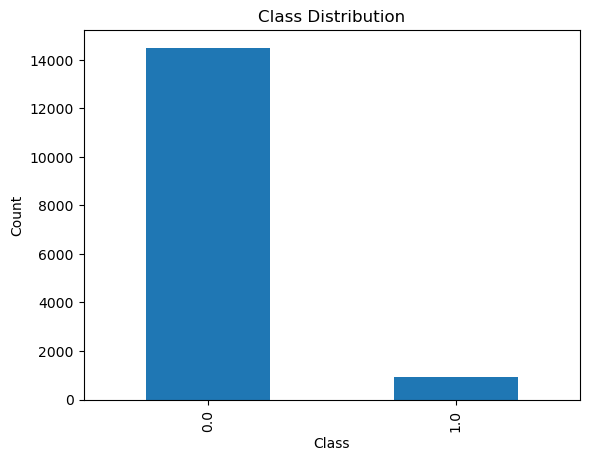

In [5]:
# Check the class distribution before oversampling
print("Class distribution before oversampling:")
print(Counter(df['FraudFound_P']))

# Visualise the distribution
df['FraudFound_P'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# K-Fold Cross-Validation Splitting with SMOTE
#### Split the dataset through k-fold cross-validation

In [6]:
X = df.drop(columns='FraudFound_P').values
y = df['FraudFound_P'].values

# K-Fold cross-validator
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
accuracies = []
reports = []
confusion_matrices = []
auprcs = []

for train_index, test_index in kf.split(X):
    # Split data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Apply SMOTE to the training set
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Random Forest

Accuracy: 0.933852140077821
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      1442
         1.0       0.33      0.02      0.04       100

    accuracy                           0.93      1542
   macro avg       0.63      0.51      0.50      1542
weighted avg       0.90      0.93      0.91      1542



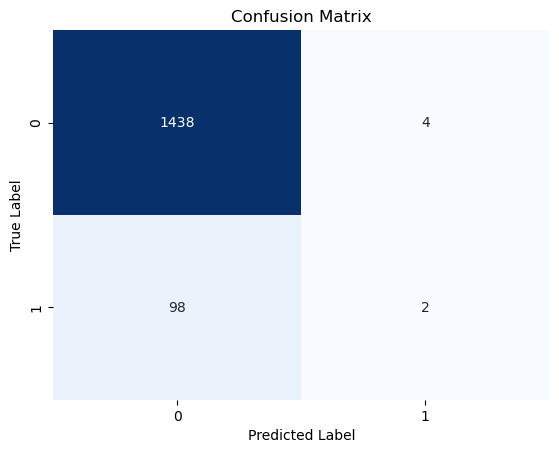

AUPRC: 0.20388296989752702


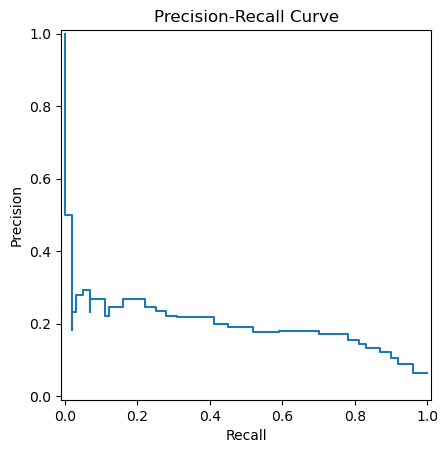

In [7]:
# Train Random Forest model
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
    
# Predict on the test set
y_pred = rf.predict(X_test)
    
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
    
# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
    
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualise the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Precision-Recall curve
y_scores = rf.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

#Calculate AUPRC
auprc = auc(recall, precision)
print("AUPRC:", auprc)

# Plot precision-recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()

# Logistic Regression

C:\Users\polin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6083009079118028
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.59      0.74      1442
         1.0       0.13      0.89      0.23       100

    accuracy                           0.61      1542
   macro avg       0.56      0.74      0.48      1542
weighted avg       0.93      0.61      0.70      1542



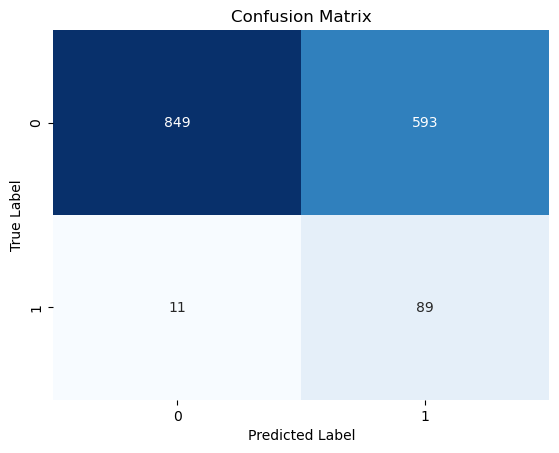

AUPRC: 0.13519243148181


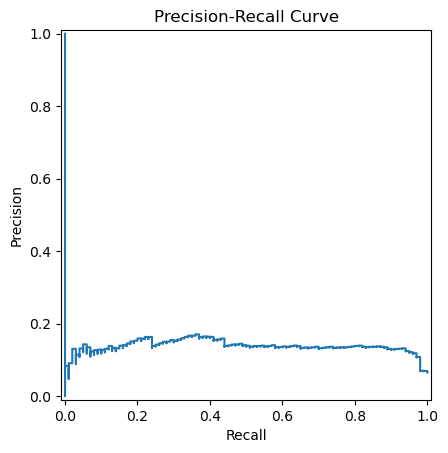

In [8]:
# Initialise the Logistic Regression model
lr = LogisticRegression(random_state=42)

# Fit the model with the training data
lr.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = lr.predict(X_test)
    
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
    
# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
    
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualise the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Precision-Recall curve
y_scores = lr.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

#Calculate AUPRC
auprc = auc(recall, precision)
print("AUPRC:", auprc)

# Plot precision-recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()

# KNN

Accuracy: 0.7075226977950714
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.73      0.82      1442
         1.0       0.09      0.40      0.15       100

    accuracy                           0.71      1542
   macro avg       0.52      0.56      0.49      1542
weighted avg       0.89      0.71      0.78      1542



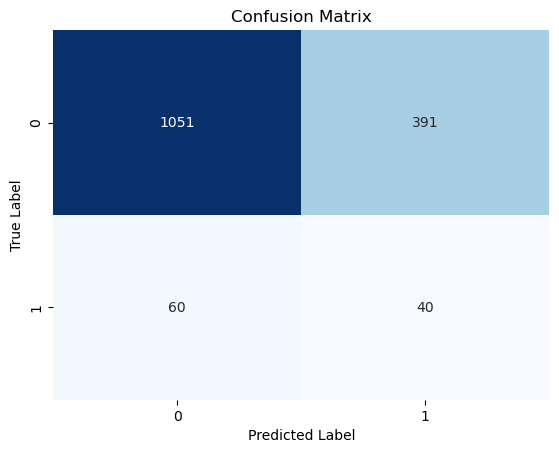

AUPRC: 0.1684252094938887


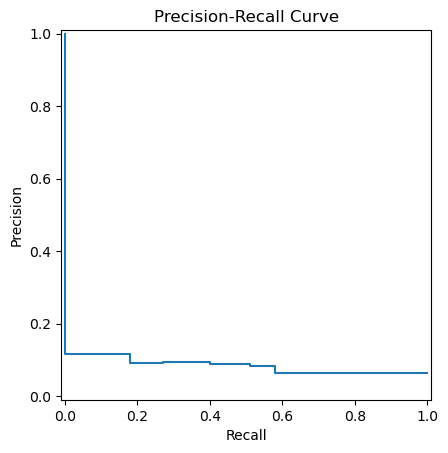

In [9]:
# Initialise the kNN model
knn = KNeighborsClassifier(n_neighbors=5) 

# Fit the model with the training data
knn.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = knn.predict(X_test)
    
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
    
# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
    
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualise the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Precision-Recall curve
y_scores = knn.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

#Calculate AUPRC
auprc = auc(recall, precision)
print("AUPRC:", auprc)

# Plot precision-recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()

# Naive Bayes

Accuracy: 0.5998702983138781
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.58      0.73      1442
         1.0       0.12      0.86      0.22       100

    accuracy                           0.60      1542
   macro avg       0.55      0.72      0.47      1542
weighted avg       0.93      0.60      0.70      1542



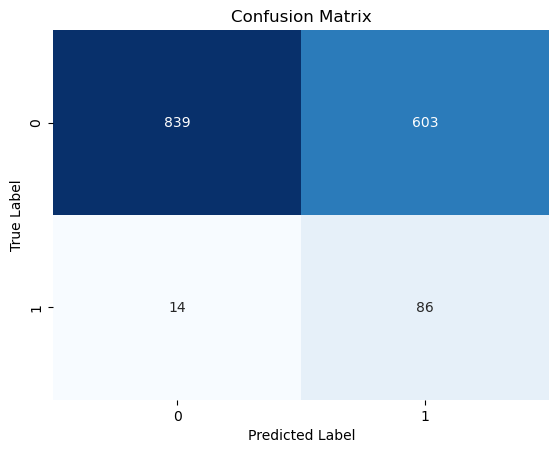

AUPRC: 0.12448007607743969


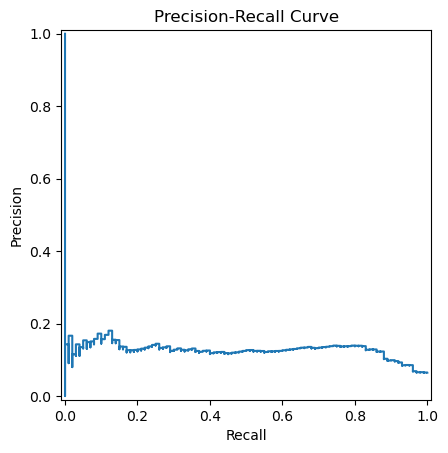

In [10]:
# Initialise the naive bayes model
nb = GaussianNB() 

# Fit the model with the training data
nb.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = nb.predict(X_test)
    
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
    
# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
    
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualise the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Precision-Recall curve
y_scores = nb.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

#Calculate AUPRC
auprc = auc(recall, precision)
print("AUPRC:", auprc)

# Plot precision-recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()

## Random Forest - Feature Importance

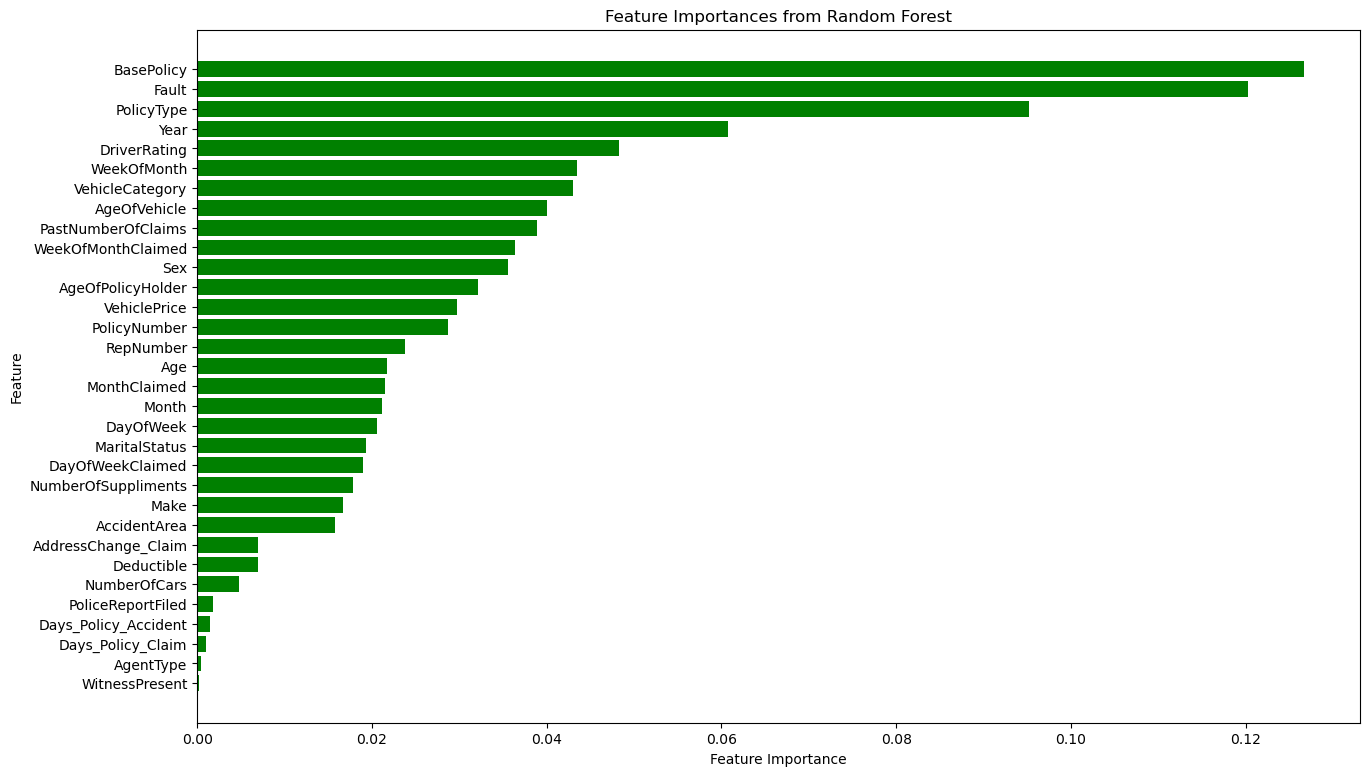

In [11]:
feature_names = ['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
                 'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
                 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
                 'VehiclePrice', 'PolicyNumber', 'RepNumber', 'Deductible',
                 'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
                 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
                 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year', 'BasePolicy']

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to hold feature names and their importances
features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 9))
plt.barh(features_df['Feature'], features_df['Importance'], color='green')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()
